In [2]:
import sys
sys.path.append('/home/jlbernal/preLIMinary/')
sys.path.append('/home/jlbernal/lim')
from lim import lim
import numpy as np
import astropy.units as u
import astropy.constants as cu
from SkyLine import make_lightcone, make_survey, make_measurements
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmap
from scipy.interpolate import interp1d, RegularGridInterpolator

import healpy as hp
from scipy import integrate
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

LC_path='/home/jlbernal/LightCone_S82_UM/'

palette=['#1a4b6e', '#d4a95b', '#b3592e', '#3c651e', '#9B88B5', '#5f685f']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=palette)
plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5

In [3]:
import copy
import pmesh
import pickle

In [4]:
def save_pickle(name,obj):
    '''
    name without extension
    '''
    with open(name+'.pickle', 'wb') as handle:
        pickle.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)
    return

def load_pickle(name):
    '''
    name without extensions
    '''
    with open(name+'.pickle', 'rb') as handle:
        obj = pickle.load(handle)
    return obj

# set the models

In [49]:
def LC_params(line,zminobs,zmaxobs):
    h=0.678
    
    zmid=(zminobs+zmaxobs)/2
    R=100
    zmin,zmax = 0.17,6.7
    ang_lim=4*u.deg
    
    model_params=dict(halo_lightcone_dir=LC_path, 
                      do_external_SFR = False, external_SFR = '',
                      SFR_pars=dict(),
                      resampler='cic',
                      angular_supersample=8,
                      spectral_supersample=8,
                      do_downsample=False,
                      cube_mode='inner_cube',
                      Nmu=30,
                      kmax=1*u.Mpc**-1,
                      dk=0.02*u.Mpc**-1,
                      seed=1234)
    obs_params=dict(zmin = zmin-0.03, zmax = zmax+0.1, 
                    RAObs_width=ang_lim, DECObs_width=ang_lim,
                    RA_width=ang_lim, DEC_width=ang_lim,
                    Nfeeds=1000, beam_FWHM=2*u.arcmin, tobs=6000*u.hr, 
                    do_angular_smooth=True, do_spectral_smooth=True)
    
    if line=='CO':
        nu_CO=115.271*u.GHz
        dnu=nu_CO/(1+zmid)/R
        model_params.update(dict(lines=dict(CO_J10=True), target_line = 'CO_J10',
                                #models=dict(CO_J10=dict(model_name='CO_Li16',
                                #                    model_pars={'alpha':1.37,'beta':-1.74,'delta_mf':1,'sigma_L':0.3})),
                                 models=dict(CO_J10=dict(model_name='CO_lines_scaling_LFIR',
                                                          model_pars={'alpha':0.67403184,'beta':4.89800039,'alpha_std':0,'beta_std':0,'sigma_L':0.2})),
                                 LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10),                          
                                 do_intensity=False))
        obs_params.update(dict(nuObs_max=nu_CO/(1+zminobs), nuObs_min=nu_CO/(1+zmaxobs),
                           dnu=dnu, 
                           Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='CII':
        nu_CII=1900.539*u.GHz
        dnu=nu_CII/(1+zmid)/R
        model_params.update(dict(lines=dict(CII=True),target_line = 'CII',
                          models=dict(CII=dict(model_name='CII_Lagache18',
                                               model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})),
                          do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_CII/(1+zminobs), nuObs_min=nu_CII/(1+zmaxobs),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    
    elif line=='Lyalpha':
        nu_Lya=2465398.5*u.GHz
        dnu=nu_Lya/(1+zmid)/R
        model_params.update(dict(lines=dict(Lyalpha=True),target_line = 'Lyalpha',
                                 models=dict(Lyalpha=dict(model_name='Lyalpha_Chung19',
                                                          model_pars={'C':1.6e42,'xi':1.6,'zeta':0.5,
                                                                      'psi':0.875,'z0':3.125,'f0':0.18,
                                                                      'SFR0':0.5,'sigma_L':0.3})),
                                 do_intensity=True))
        obs_params.update(dict(nuObs_max=nu_Lya/(1+zminobs), nuObs_min=nu_Lya/(1+zmaxobs),
                               dnu=dnu,
                               Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
        
    elif line=='HI':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':1.5e10*u.Msun/h, 'Mmin':6.7e10*u.Msun/h, 
                                                                 'alpha':0.76,'sigma_MHI':0.2})),
                                 do_intensity=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zminobs), nuObs_min=nu_HI/(1+zmaxobs),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    elif line=='lrg':
        nu_HI=1.4204134*u.GHz
        dnu=nu_HI/(1+zmid)/R
        model_params.update(dict(lines=dict(HI=True),target_line = 'HI',
                                 models=dict(HI=dict(model_name='HI_VN18',
                                                     model_pars={'M0':2.9e9*u.Msun/h, 'Mmin':6e11*u.Msun/h, 
                                                                 'alpha':0.53,'sigma_MHI':0.2})),
                                 do_intensity=False,
                                gal_type='lrg',ngal=ngal,number_count=True,
                                do_angular_smooth=False, do_spectral_smooth=False))
        obs_params.update(dict(zmin = zmin-0.03, zmax = zmax+0.03,
                               nuObs_max=nu_HI/(1+zminobs), nuObs_min=nu_HI/(1+zmaxobs),
                        dnu=dnu,
                        Tsys=0*u.Jy/u.sr))
        obs_params.update(model_params)
    return obs_params

# call the lightcones and run maps

In [50]:
LC = make_measurements(LC_params('CII',5.5,6.5))

In [51]:
r3,r4,r5,r6,r7 = 0.73,0.57,0.32,0.19,0.1

In [52]:
alpha,beta = 0.81568736,3.43531917

LC.update(lines=dict(CO_J32=True),
          models=dict(CO_J32=dict(model_name='CO_lines_scaling_LFIR',
                                
                                  model_pars={'alpha':alpha,'beta':beta-alpha*np.log10(r3),'sigma_L':0.2})),
                     LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10))


In [53]:
CO_J32_map=LC.obs_3d_map
PkCO_J32=LC.Pk_0
kCO_J32=LC.k_Pk_poles

CO_J32_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Npixside[0],LC.Npixside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J32_map_lowgrade = pm_noise.downsample(CO_J32_map_lowgrade.c2r(),keep_mean=True)



/home/jlbernal/preLIMinary/source/survey.py:876: UserWarning: % of emitters of CO_J32 line left out filtering = 0.06992884499760921
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [54]:
Nbins=50
Ie_COJ32 = np.logspace(-1,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ32 = 0.5*(Ie_COJ32[:-1]+Ie_COJ32[1:])
VID_COJ32 = np.histogram(CO_J32_map_lowgrade.value.flatten(),
                            bins=Ie_COJ32.value)[0]

In [55]:
CO32q = dict(k=kCO_J32.to(u.Mpc**-1),Pk=PkCO_J32.to(LC.unit**2*u.Mpc**3),I=Ii_COJ32,VID=VID_COJ32)
save_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CO32q',CO32q)


In [56]:
alpha,beta = 0.81568736,3.43531917

LC.update(lines=dict(CO_J43=True),
          models=dict(CO_J43=dict(model_name='CO_lines_scaling_LFIR',
                                  model_pars={'alpha':alpha,'beta':beta-alpha*np.log10(r4),'sigma_L':0.2})),
         LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10))


In [57]:
CO_J43_map=LC.obs_3d_map
PkCO_J43=LC.Pk_0
kCO_J43=LC.k_Pk_poles

CO_J43_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Npixside[0],LC.Npixside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J43_map_lowgrade = pm_noise.downsample(CO_J43_map_lowgrade.c2r(),keep_mean=True)



/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.05956707625270097
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:876: UserWarning: % of emitters of CO_J43 line left out filtering = 0.07481240792859756
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [58]:
Nbins=50
Ie_COJ43 = np.logspace(-1,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ43 = 0.5*(Ie_COJ43[:-1]+Ie_COJ43[1:])
VID_COJ43 = np.histogram(CO_J43_map_lowgrade.value.flatten(),
                            bins=Ie_COJ43.value)[0]

In [59]:
CO43q = dict(k=kCO_J43.to(u.Mpc**-1),Pk=PkCO_J43.to(LC.unit**2*u.Mpc**3),I=Ii_COJ43,VID=VID_COJ43)
save_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CO43q',CO43q)


In [60]:
alpha,beta = 0.81568736,3.43531917

LC.update(lines=dict(CO_J54=True),
          models=dict(CO_J54=dict(model_name='CO_lines_scaling_LFIR',
                                  model_pars={'alpha':alpha,'beta':beta-alpha*np.log10(r5),'sigma_L':0.2})),
         LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10))


In [61]:
CO_J54_map=LC.obs_3d_map
PkCO_J54=LC.Pk_0
kCO_J54=LC.k_Pk_poles

CO_J54_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Npixside[0],LC.Npixside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J54_map_lowgrade = pm_noise.downsample(CO_J54_map_lowgrade.c2r(),keep_mean=True)



/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.05956707625270097
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:876: UserWarning: % of emitters of CO_J54 line left out filtering = 0.07667102315952312
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [62]:
Nbins=50
Ie_COJ54 = np.logspace(-1,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ54 = 0.5*(Ie_COJ54[:-1]+Ie_COJ54[1:])
VID_COJ54 = np.histogram(CO_J54_map_lowgrade.value.flatten(),
                            bins=Ie_COJ54.value)[0]

In [63]:
CO54q = dict(k=kCO_J54.to(u.Mpc**-1),Pk=PkCO_J54.to(LC.unit**2*u.Mpc**3),I=Ii_COJ54,VID=VID_COJ54)
save_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CO54q',CO54q)


In [64]:
alpha,beta = 0.81568736,3.43531917

LC.update(lines=dict(CO_J65=True),
          models=dict(CO_J65=dict(model_name='CO_lines_scaling_LFIR',
                                  model_pars={'alpha':alpha,'beta':beta-alpha*np.log10(r6),'sigma_L':0.2})),
         LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10))


In [65]:
CO_J65_map=LC.obs_3d_map
PkCO_J65=LC.Pk_0
kCO_J65=LC.k_Pk_poles

CO_J65_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Npixside[0],LC.Npixside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J65_map_lowgrade = pm_noise.downsample(CO_J65_map_lowgrade.c2r(),keep_mean=True)



/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.05956707625270097
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:876: UserWarning: % of emitters of CO_J65 line left out filtering = 0.07132980732120675
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [66]:
Nbins=50
Ie_COJ65 = np.logspace(-1,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ65 = 0.5*(Ie_COJ65[:-1]+Ie_COJ65[1:])
VID_COJ65 = np.histogram(CO_J65_map_lowgrade.value.flatten(),
                            bins=Ie_COJ65.value)[0]

In [67]:
CO65q = dict(k=kCO_J65.to(u.Mpc**-1),Pk=PkCO_J65.to(LC.unit**2*u.Mpc**3),I=Ii_COJ65,VID=VID_COJ65)
save_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CO65q',CO65q)


In [68]:
alpha,beta = 0.81568736,3.43531917

LC.update(lines=dict(CO_J76=True),
          models=dict(CO_J76=dict(model_name='CO_lines_scaling_LFIR',
                                  model_pars={'alpha':alpha,'beta':beta-alpha*np.log10(r7),'sigma_L':0.2})),
         LIR_pars = dict(IRX_name='Bouwens2020', log10Ms_IRX=9.15, alpha_IRX=0.97, sigma_IRX=0.2,
                                                 K_IR=0.63*1.73e-10, K_UV=0.63*2.5e-10))


In [69]:
CO_J76_map=LC.obs_3d_map
PkCO_J76=LC.Pk_0
kCO_J76=LC.k_Pk_poles

CO_J76_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Npixside[0],LC.Npixside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CO_J76_map_lowgrade = pm_noise.downsample(CO_J76_map_lowgrade.c2r(),keep_mean=True)



/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.05956707625270097
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:876: UserWarning: % of emitters of CO_J76 line left out filtering = 0.07187511922437906
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [70]:
Nbins=50
Ie_COJ76 = np.logspace(-1,np.log10(2e4),Nbins+1)*LC.unit       
Ii_COJ76 = 0.5*(Ie_COJ76[:-1]+Ie_COJ76[1:])
VID_COJ76 = np.histogram(CO_J76_map_lowgrade.value.flatten(),
                            bins=Ie_COJ76.value)[0]

In [71]:
CO76q = dict(k=kCO_J76.to(u.Mpc**-1),Pk=PkCO_J76.to(LC.unit**2*u.Mpc**3),I=Ii_COJ76,VID=VID_COJ76)
save_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CO76q',CO76q)


In [72]:
LC.update(lines=dict(CII=True),
        models=dict(CII=dict(model_name='CII_Lagache18',
                            model_pars={'alpha1':1.4,'alpha2':-0.07, 'beta1':7.1, 'beta2':-0.07, 'sigma_L':0.5})))


In [73]:
CII_L18_map=LC.obs_3d_map
PkCII_L18=LC.Pk_0
kCII_L18=LC.k_Pk_poles

CII_L18_map_lowgrade = copy.copy(LC.obs_3d_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Npixside[0],LC.Npixside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
CII_L18_map_lowgrade = pm_noise.downsample(CII_L18_map_lowgrade.c2r(),keep_mean=True)



/home/jlbernal/preLIMinary/source/survey.py:348: UserWarning: % of survey volume lost due to inner cube = 0.05956707625270097
  warn("% of survey volume lost due to inner cube = {}".format(1-zside*raside*decside*self.Mpch**3/self.Vsurvey))
/home/jlbernal/preLIMinary/source/survey.py:876: UserWarning: % of emitters of CII line left out filtering = 0.05682977247691445
  warn("% of emitters of {} line left out filtering = {}".format(line, 1-len(Zhalo)/len(filtering)))


In [74]:
Nbins=50
Ie_CII_L18 = np.logspace(-1,np.log10(2e4),Nbins+1)*LC.unit       
Ii_CII_L18 = 0.5*(Ie_CII_L18[:-1]+Ie_CII_L18[1:])
VID_CII_L18 = np.histogram(CII_L18_map_lowgrade.value.flatten(),
                            bins=Ie_CII_L18.value)[0]

In [75]:
CII_L18q = dict(k=kCII_L18.to(u.Mpc**-1),Pk=PkCII_L18.to(LC.unit**2*u.Mpc**3),I=Ii_CII_L18,VID=VID_CII_L18)
save_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CII_L18q',CII_L18q)


In [76]:
from nbodykit.algorithms import FFTPower
from nbodykit.source.mesh.catalog import CompensateCICShotnoise


In [77]:
ALL_map = CO_J32_map  + CO_J43_map + CO_J54_map + CO_J65_map + CO_J76_map + CII_L18_map

ALL_map = (ALL_map.r2c().apply(CompensateCICShotnoise, kind='circular')).c2r()
    
Pk2dALL = FFTPower(ALL_map, '2d', Nmu=LC.Nmu, poles=[0,2,4], los=[1,0,0],
                                dk=LC.dk.to(LC.Mpch**-1).value,kmin=LC.kmin.to(LC.Mpch**-1).value,
                                kmax=LC.kmax.to(LC.Mpch**-1).value,BoxSize=LC.Lbox.value)

PkALL=(Pk2dALL.poles['power_0'].real*LC.Mpch**3).to(LC.Mpch**3)*LC.unit**2

kALL=(Pk2dALL.poles['k']*LC.Mpch**-1).to(LC.Mpch**-1)

ALL_map_lowgrade = copy.copy(ALL_map.r2c())
pm_noise = pmesh.pm.ParticleMesh(np.array([LC.Nchan,LC.Npixside[0],LC.Npixside[1]], dtype=int),
                                        BoxSize=LC.Lbox.value, dtype='float32', resampler='cic')
ALL_map_lowgrade = pm_noise.downsample(ALL_map_lowgrade.c2r(),keep_mean=True)



In [78]:
Nbins=50
Ie_ALL = np.logspace(-1,np.log10(2e4),Nbins+1)*LC.unit           
Ii_ALL = 0.5*(Ie_ALL[:-1]+Ie_ALL[1:])
VID_ALL = np.histogram(ALL_map_lowgrade.value.flatten(),
                            bins=Ie_ALL.value)[0]

In [79]:
ALLq = dict(k=kALL.to(u.Mpc**-1),Pk=PkALL.to(LC.unit**2*u.Mpc**3),I=Ii_ALL,VID=VID_ALL)
save_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_ALLq',ALLq)


In [80]:
np.savez('/home/jlbernal/lim_LC_prods/interlopers.npz',CO32=CO_J32_map,CO43=CO_J43_map,CO54=CO_J54_map,CO65=CO_J65_map,
                             CO76=CO_J76_map,CII_L18=CII_L18_map,ALL=ALL_map)



# Make the plot

In [81]:
def makemap(cols):
    cmap = clrs.LinearSegmentedColormap.from_list("", cols)
    return cmap

def dispmap(cols):
    f,axes = plt.subplots(figsize=(8,0.5), dpi=100,sharey=True)
    f.subplots_adjust(wspace=0,right=0.99,top=0.99,bottom=0.00,left=0.01,hspace=0.0)
    plt.yticks([])
    arr=np.tile(np.arange(1000),100).reshape(100,1000)
    cmap = makemap(cols)
    plt.imshow(arr,cmap=cmap)

In [102]:
shironeri    = '#FCFAF2'
seiheki   = '#478384'
ake       = '#BA2636'
shikon    = '#400B36'
koiai       = '#002E4E'
aiiro     = '#105779'
kujyaku   = '#008E74'
shuan     = '#740A00'
suo       = '#7E2639'
kitsune   = '#D9972F'
tamago    = '#FFDF85'
ominaeshi   = '#F2F2B0'
chojizome = '#DDB87E'
azuki     = '#A04940'
kitsune   = '#D9972F'
seiheki   = '#478384'
aonibi      = '#324356'
shion       = '#968ABD'


grey='#324356'
turquoise='#54858a'
#aqua='#5ca191'
yellow='#f0db92'
yellow_orange='#edc080'
orange='#C37854'
gabimap = matplotlib.colors.LinearSegmentedColormap.from_list("", [grey,turquoise,yellow,yellow_orange,orange])

cm = makemap([shironeri,palette[2],shikon][::-1])
norm = clrs.Normalize(vmin=2,vmax=8)
cb_CO = cmap.ScalarMappable(cmap=cm, norm=norm)
cb_CO.set_array([])

map_br2 = makemap([grey,koiai,seiheki,'#f3d991',orange,azuki,shuan])
map_br = makemap([grey,seiheki,'#f3d991',orange,shuan])


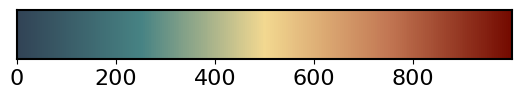

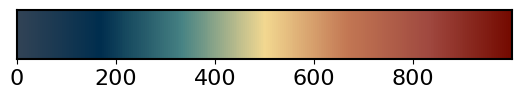

In [110]:
dispmap([grey,seiheki,'#f3d991',orange,shuan])
dispmap([grey,koiai,seiheki,'#f3d991',orange,azuki,shuan])

In [83]:
import matplotlib.gridspec as gridspec


In [84]:
interlopers = np.load('/home/jlbernal/lim_LC_prods/interlopers.npz')

#load quantities
CO32q = load_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CO32q')#('../../LIM_projects/interlop_LC_CO32q')
CO43q = load_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CO43q')#('../../LIM_projects/interlop_LC_CO43q')
CO54q = load_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CO54q')#('../../LIM_projects/interlop_LC_CO54q')
CO65q = load_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CO65q')#('../../LIM_projects/interlop_LC_CO65q')
CO76q = load_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CO76q')#('../../LIM_projects/interlop_LC_CO76q')
CIIq = load_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_CII_L18q')#('../../LIM_projects/interlop_LC_CII_L18q')
ALLq = load_pickle('/home/jlbernal/lim_LC_prods/interlop_LC_ALLq')#('../../LIM_projects/interlop_LC_ALLq')



In [85]:
all_proj = np.sum(interlopers['ALL'],axis=0)
cii_proj = np.sum(interlopers['CII_L18'],axis=0)

In [86]:
ralim=np.asarray([-2,2])
declim=np.asarray([-2,2])
z_plot=np.asarray([5.5,6.5])
ra,dec  = np.deg2rad(ralim),np.deg2rad(declim)
x = np.cos(dec) * np.cos(ra)
y = np.cos(dec) * np.sin(ra)
z = np.sin(dec)
pos_lims = np.vstack([x,y,z]).T

r = ((LC.cosmo.comoving_radial_distance(z_plot)*u.Mpc).to(LC.Mpch)).value
grid_lim = r[:,None]*pos_lims

x=np.linspace(0, grid_lim[1,1]- grid_lim[0,1], 100)
y=np.linspace(0, grid_lim[1,2]-grid_lim[0,2], 100)

In [95]:
cii_proj[360:-360,360:-360].shape

(240, 240)

<ipython-input-109-486def112677>:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


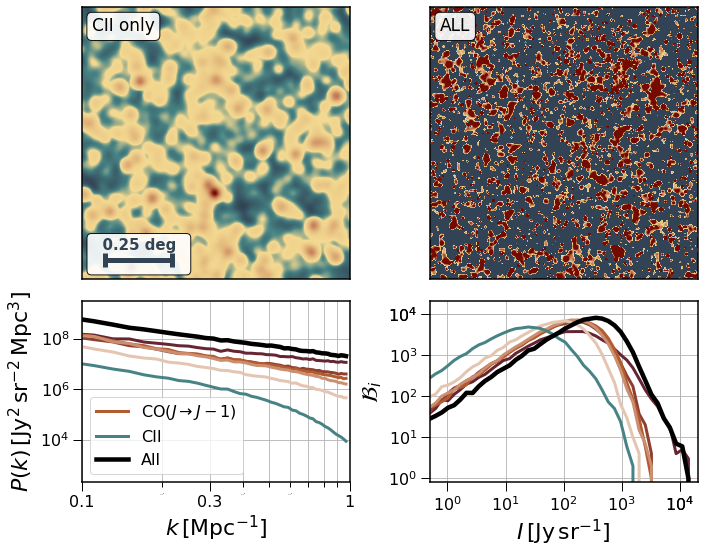

In [109]:
gs_plot = gridspec.GridSpec(2,2,left=0.12,bottom=0.11,right=0.975,top=0.99,
                            wspace=.3,hspace=.1,height_ratios=[3,2])
fig = plt.figure(figsize=(10,7.5))

norm = clrs.TwoSlopeNorm(vcenter=0)

######## MAPS ########

#gs_plot2 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs_plot[:-1,:],hspace=0.1,wspace=0.25,height_ratios=[8,1])

ax = plt.subplot(gs_plot[0,0])
#norm = clrs.TwoSlopeNorm(vcenter=0,vmin=np.min(CO_J43_map.preview(axes=[2,1]),vmax=np.max(np.max(CO_J43_map.preview(axes=[2,1]))))

cb = ax.imshow(cii_proj[360:-360,360:-360], extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(15,15,'CII only', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',va='top',fontsize=17)
ax.set_xticks([])
ax.set_yticks([])
rside = x[-1]-x[0]
side = rside/8
cent = 20+side+15
height = y[-1]-y[0]
ax.text(cent,height*0.85,'  0.25 deg  \n', color=aonibi,weight='bold',ha='center',fontsize=15,bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),va='top')
ax.errorbar(cent,height*0.93,xerr=side,marker='',ls='--',c=aonibi,elinewidth=5,capsize=7,capthick=5,zorder=10)
#rside = x[-1]-x[0]
#cent = rside/5
#side = rside/10
#ax.errorbar(cent,y[-1]-7,xerr=side,marker='',ls='--',c=shironeri,elinewidth=5,capsize=10,capthick=5)
#ax.text(cent,y[-1]-10,r'0.2 deg', color=shironeri,weight='bold',ha='center',va='bottom')

ax = plt.subplot(gs_plot[0,1])
#norm = clrs.TwoSlopeNorm(vcenter=0,vmin=np.min(CO_J65_map.preview(axes=[2,1])),vmax=np.max(np.max(CO_J65_map.preview(axes=[2,1]))))
ax.imshow(all_proj[360:-360,360:-360], extent=[x[0],x[-1], y[-1], y[0]], cmap=map_br,norm=norm,aspect='auto')
#plt.xlabel('Mpc/h')
ax.text(15,15,'ALL', bbox=dict(boxstyle="round",facecolor='white', alpha=0.9),ha='left',va='top',fontsize=17)
ax.set_xticks([])
ax.set_yticks([])

######### COLORBAR ##############

#cbar = plt.colorbar(cb,orientation='horizontal',cax=plt.subplot(gs_plot2[1,:]))
#cbar.ax.set_xlabel(r'$\delta I\, \left[{\rm Jy\,sr^{-1}}\right]$', fontsize=24,labelpad = 10)
#cbar.ax.tick_params(labelsize=19,size = 8.) 


######## PK ########

ax = plt.subplot(gs_plot[1,0])
ax.loglog(CO32q['k'], CO32q['Pk'],lw=3,c=cb_CO.to_rgba(3))
ax.loglog(CO43q['k'], CO43q['Pk'],lw=3,c=cb_CO.to_rgba(4))
ax.loglog(CO54q['k'], CO54q['Pk'],lw=3,c=cb_CO.to_rgba(5),label=r'CO($J\rightarrow J-1$)')
ax.loglog(CO65q['k'], CO65q['Pk'],lw=3,c=cb_CO.to_rgba(6))
ax.loglog(CO76q['k'], CO76q['Pk'],lw=3,c=cb_CO.to_rgba(7))
ax.loglog(CIIq['k'], CIIq['Pk'],lw=3,c=seiheki, label=r'CII')
ax.loglog(ALLq['k'], ALLq['Pk'],lw=4.5,color='k',label=r'All')

ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=0)
ax.legend(loc=3,fontsize=16,ncol=1)
ax.grid(which='both',axis='x')
ax.grid(axis='y')
ax.set_xlim(0.1,1)
ax.set_xticks([0.1,0.3,1])
ax.set_xticklabels(['0.1','0.3','1'])
ax.set_ylim(2e2,3e9)
ax.set_xlabel(r'$k\,[{\rm Mpc^{-1}}]$',fontsize=22)
ax.set_ylabel(r'$P(k)\,[{\rm Jy^2\,sr^{-2}\,Mpc^{3}}]$',fontsize=22)

######## VID #######

ax = plt.subplot(gs_plot[1,1])
ax.loglog(CO32q['I'], CO32q['VID'],lw=3,c=cb_CO.to_rgba(3))
ax.loglog(CO43q['I'], CO43q['VID'],lw=3,c=cb_CO.to_rgba(4))
ax.loglog(CO54q['I'], CO54q['VID'],lw=3,c=cb_CO.to_rgba(5))
ax.loglog(CO65q['I'], CO65q['VID'],lw=3,c=cb_CO.to_rgba(6))
ax.loglog(CO76q['I'], CO76q['VID'],lw=3,c=cb_CO.to_rgba(7))
ax.loglog(CIIq['I'], CIIq['VID'],lw=3,c=seiheki)
ax.loglog(ALLq['I'], ALLq['VID'],lw=4.5,color='k')

ax.tick_params(axis='both',width=1,length=9,labelsize=16)
ax.tick_params(axis='both',which='minor',width=1,length=5,labelsize=16)
ax.grid()
ax.set_xlabel(r'$I\,[{\rm Jy\,sr^{-1}}]$',fontsize=22)
ax.set_ylabel(r'$\mathcal{B}_i$',fontsize=22)
ax.set_xlim(0.5,2e4)
ax.set_ylim(0.8,2e4)
ax.set_xticks([1,10,100,1000,10000,1e4])
ax.set_yticks([1,10,100,1000,10000,1e4])

plt.tight_layout()
plt.savefig('/home/jlbernal/lim_LC_prods/LC_LIM_interloper_maps.pdf', dpi=600)
plt.show()